In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
%matplotlib inline
import csv

import scipy.optimize as op
import scipy.stats
from scipy.optimize import curve_fit
import scipy.io
from scipy.stats import rice

import random
import pickle
import seaborn as sns

import numpy as np
from scipy.stats import ttest_ind, ttest_ind_from_stats, wilcoxon,ttest_rel, pearsonr,shapiro,f_oneway, ranksums
from scipy.special import stdtr
import csv
import pandas as pd

from scipy.integrate import quad
import sys 
import os
#sys.path.append(os.path.abspath("/Users/neuroimaging/Desktop/MR-code/Python_Code"))

#from ML_UsefulFunctions import *
#from KidneyROIAnalyses import *

from scipy import special

from scipy.integrate import tplquad

pd.options.display.float_format = '{:.3f}'.format


from sklearn.feature_selection import SequentialFeatureSelector

import warnings
warnings.simplefilter("ignore")


from EllipsoidalSimulationCode import *

from statistics import mean

In [61]:
def Calc_FA(a,b,c):
    MD = (a+b+c)/3
    num = np.sqrt((a-MD)**2 + (b-MD)**2 + (c-MD)**2)
    denom = np.sqrt(a**2 + b**2 + c**2)
    return np.sqrt(3/2)*num/denom

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

def GenerateFA_Ellipsoid(FA_want,FAs,abcs):
    val,idx = find_nearest(FAs,FA_want)
    return abcs[idx]#, val, FA_want #, FA(abcs[idx][0],abcs[idx][1],abcs[idx][2])

def Scale_Ds(D_traces,abc_s,thetas):
    D_thetas = np.zeros(len(D_traces))
    for n in range(len(D_traces)): #here n is fast, medium, or slow compartments. i.e. the 3 ellipsoids
        D_n = 3*D_traces[n]/sum(abc_s[n]) #normalize to ellipsoid (basically normalize to 1)
        D_thetas[n] = D_n*thetas[n] #multiply by diffusion strength along b-value direction 
    return D_thetas



#create an ellipsoid with a given FA
#rotate it within the lab frame (i.e. slow compartment is tilted k-degrees in lab frame while fast compartment is tilted h-degrees in lab frame)
def generate_rotated_anisotropic_ellipsoid(FA,compartment_rotations):
    # FAs and abcs are just previously generated potentials to choose from
    FAs = np.zeros(100)
    abcs = np.empty([100,3])
    for j in range(1,100): #creating an elipsoid
        abc3 = [1,random.uniform(0.01,1),random.uniform(0.01,1)]
        #print(abc3)
        FAs[j] = (Calc_FA(abc3[0],abc3[1],abc3[2]))
        abcs[j,:] = abc3
    abc = GenerateFA_Ellipsoid(FA,FAs,abcs) #getting the ellipsoidal dimensions
    a = abc[0] # i.e. Ax
    b = abc[1] # i.e. By
    c = abc[2] # i.e. Cz
    #set up innitial 3d ellipsoid
    A = np.array([[a,0,0],[0,b,0],[0,0,c]])
    center = [0,0,0]
    eigenvectors,eigenvalues,rotated = np.linalg.svd(A) #ignore 'rotated' as it's made in standard xyz, then will be rotated
    theta = np.linspace(0.0, np.pi, 100) #cover all angles to build ellipsoid
    phi = np.linspace(0.0, 2.0 * np.pi, 100)  #cover all angles to build ellipsoid
    #get major axes
    x = eigenvalues[0] * np.outer(np.cos(theta), np.sin(phi))
    y = eigenvalues[1] * np.outer(np.sin(theta), np.sin(phi))
    z = eigenvalues[2] * np.outer(np.ones_like(theta), np.cos(phi))
    
    #rotate by compartment_dependent lab-frame angles
    rotation = Rxyz(compartment_rotations)
    for i in range(len(x)):
        for j in range(len(x)):
            [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], rotation) + center
    return x,y,z,abc


#give all fractional anisotropies and their lab-frame rotations to generate the three compartment ellipsoids up front
def CreateThreeEllipsoidalCompartments(All_FAs, All_rotations):
    FA_fast, FA_med, FA_slow = All_FAs[0],All_FAs[1], All_FAs[2] # the anisotropies
    fastrot,medrot,slowrot = All_rotations[0], All_rotations[1], All_rotations[2] #the original ellipsoid rotations (in the lab frame, so not all aligned in same direction)
    
    #create the three compartment ellipsoids rotated in lab-space, and then rotate along the b-value direction
    x_fast,y_fast,z_fast,abc_fast = generate_rotated_anisotropic_ellipsoid(FA_fast,fastrot) # but then thetaxyz are same for fast, med, slow, because it's measured in the same lab-frame direction
    x_med,y_med,z_med,abc_med = generate_rotated_anisotropic_ellipsoid(FA_med,medrot)
    x_slow,y_slow,z_slow,abc_slow = generate_rotated_anisotropic_ellipsoid(FA_slow,slowrot)
    
    fast_compartment = [x_fast,y_fast,z_fast,abc_fast]
    med_compartment = [x_med,y_med,z_med,abc_med]
    slow_compartment = [x_slow,y_slow,z_slow,abc_slow]
    return fast_compartment, med_compartment, slow_compartment

def RotateCompartments(x,y,z,thetaxyz):
    center = [0,0,0]
    rotation = Rxyz(thetaxyz)
    for i in range(len(x)):
        for j in range(len(x)):
            [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], rotation) + center
    return x,y,z

#give true D, the three ellipsoidal compartments in labframe, and the b-value direction (i.e. thetaxyz)
def GetOrthogonalD_thetas(D_traces,fast_compartment, med_compartment, slow_compartment, thetaxyz):
    
    #now "measured along 3 orthogonal diffusion directions" to get 3 single-direction b-values
    #rotate by thetaxyz
    x_fast,y_fast,z_fast = RotateCompartments(fast_compartment[0],fast_compartment[1],fast_compartment[2],thetaxyz)
    x_med,y_med,z_med = RotateCompartments(med_compartment[0],med_compartment[1],med_compartment[2],thetaxyz)
    x_slow,y_slow,z_slow = RotateCompartments(slow_compartment[0],slow_compartment[1],slow_compartment[2],thetaxyz)

    #now measure along the given b-value direction
    x_theta_fast,y_theta_fast,z_theta_fast = find_axes(x_fast,y_fast,z_fast) #just get the length of the ellipsoid along the normal axis (i.e. 3 random orthogonal directions)
    x_theta_med,y_theta_med,z_theta_med = find_axes(x_med,y_med,z_med) #just get the length of the ellipsoid along the normal axis (i.e. 3 random orthogonal directions)
    x_theta_slow,y_theta_slow,z_theta_slow = find_axes(x_slow,y_slow,z_slow) #just get the length of the ellipsoid along the normal axis (i.e. 3 random orthogonal directions)

    #now assume the single direction is measured along the x-axis (just so it's one direction)
    x_thetas = [x_theta_fast, x_theta_med, x_theta_slow]
    abc_s = [fast_compartment[3],med_compartment[3],slow_compartment[3]]
    #get the new "diffusion values" i.e. the AxD_slow, AxD_med, AxD_fast
    D_traces_b = Scale_Ds(D_traces,abc_s,x_thetas) 
    
    #now for comparison, also exporting the averaged across 3 values
    fast_averaged = mean([x_theta_fast,y_theta_fast,z_theta_fast])
    med_averaged = mean([x_theta_med,y_theta_med,z_theta_med])
    slow_averaged = mean([x_theta_slow,y_theta_slow,z_theta_slow])
    averaged_thetas = [fast_averaged, med_averaged, slow_averaged]
    D_traces_b_averaged = Scale_Ds(D_traces,abc_s,averaged_thetas) 

    return D_traces_b,D_traces_b_averaged


    

# Demonstrating the generation of an ellipsoid with approximate FA

based on 'generate_rotated_anitostropic_ellipsoid' function

Change the first line, and see the ellipsoid change, and the FA agree

wanted:  0.2 got:  0.19122371372589086


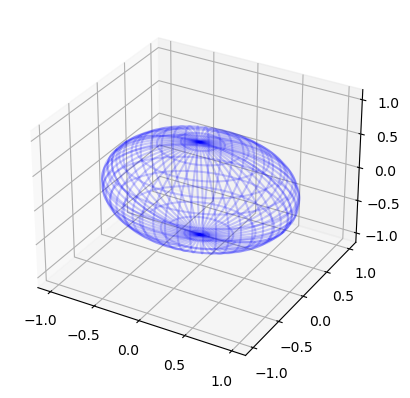

[1.         0.68679798 0.78871724]
[1.         0.78871724 0.68679798]


In [110]:
#Change the FA, and see the resulting ellipsoid with a close FA. 
FA = 0.2#[0.0,0.1,0.1] #true fractional anisotropy, proof it is all due to FA... 

#. assumed rotation is 0
assumed_rots = [[0,0,0],[0,0,0],[0,0,0]]

diff_fast   = 0.180
diff_med    = 0.0058 #[0.006 0.007 0.008 0.009 0.010];
diff_slow   = 0.0015
frac_fast   = 0.10
frac_med    = 0.30
frac_slow   = 0.60
D_traces = [diff_fast,diff_med, diff_slow] #true D coefficients

if 1 == 1:
    FAs = np.zeros(100)
    abcs = np.empty([100,3])
    for j in range(1,100): #creating an elipsoid
        abc3 = [1,random.uniform(0.01,1),random.uniform(0.01,1)]
        #print(abc3)
        FAs[j] = (Calc_FA(abc3[0],abc3[1],abc3[2]))
        abcs[j,:] = abc3
    abc = GenerateFA_Ellipsoid(FA,FAs,abcs) #getting the ellipsoidal dimensions
    a = abc[0] # i.e. Ax
    b = abc[1] # i.e. By
    c = abc[2] # i.e. Cz
    print('wanted: ', FA, 'got: ', Calc_FA(a,b,c))
    thetaxyz1= [0,0,0]
     #set up innitial 3d ellipsoid
    A = np.array([[a,0,0],[0,b,0],[0,0,c]])
    center = [0,0,0]
    eigenvectors,eigenvalues,rotated = np.linalg.svd(A) #ignore 'rotated' as it's made in standard xyz, then will be rotated
    theta = np.linspace(0.0, np.pi, 100) #cover all angles to build ellipsoid
    phi = np.linspace(0.0, 2.0 * np.pi, 100)  #cover all angles to build ellipsoid
    #get major axes
    x = eigenvalues[0] * np.outer(np.cos(theta), np.sin(phi))
    y = eigenvalues[1] * np.outer(np.sin(theta), np.sin(phi))
    z = eigenvalues[2] * np.outer(np.ones_like(theta), np.cos(phi))
    fig = pl.figure()
    ax = fig.add_subplot(111,projection='3d')
    #ax.set_aspect('equal')
    ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color='b', alpha=0.2)
    set_axes_equal(ax)
    #pl.savefig('/Users/neuroimaging/Desktop/Ellipsoid_Calc_FA41.png',format='png',dpi=120)
    pl.show()
    
    print(abc)
    print(eigenvalues)

# now set up ellipsoid with nonzero FA in 3D space, get x, y, and z values after rotation

wanted:  0.9 got:  0.8688463419939542


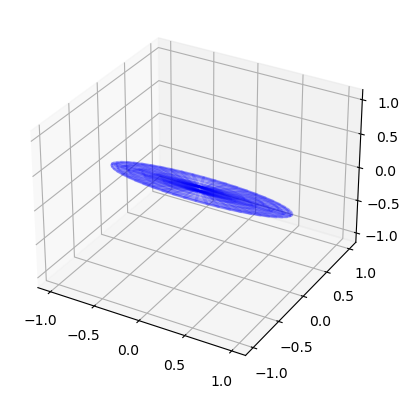

rotated by:  [0, 1.0471975511965976, 1.5707963267948966]


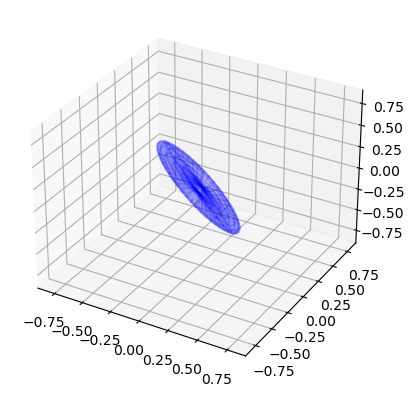

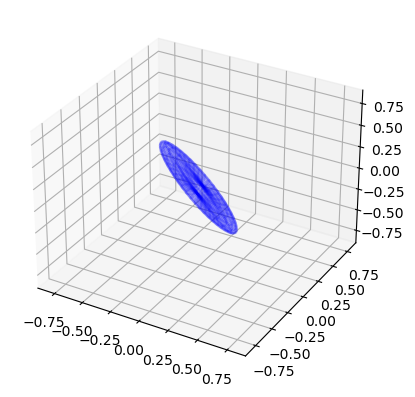

In [76]:
#Change the FA, and see the resulting ellipsoid with a close FA. 
FA = 0.9#[0.0,0.1,0.1] #true fractional anisotropy, proof it is all due to FA... 

# change the rotation and get the new ellipsoidal values
compartment_rotations = [0,np.pi/3,np.pi/2]#[[0,0,0],[0,0,0],[0,0,0]]

diff_fast   = 0.180
diff_med    = 0.0058 #[0.006 0.007 0.008 0.009 0.010];
diff_slow   = 0.0015
frac_fast   = 0.10
frac_med    = 0.30
frac_slow   = 0.60
D_traces = [diff_fast,diff_med, diff_slow] #true D coefficients

if 1 == 1:
    FAs = np.zeros(100)
    abcs = np.empty([100,3])
    for j in range(1,100): #creating an elipsoid
        abc3 = [1,random.uniform(0.01,1),random.uniform(0.01,1)]
        #print(abc3)
        FAs[j] = (Calc_FA(abc3[0],abc3[1],abc3[2]))
        abcs[j,:] = abc3
    abc = GenerateFA_Ellipsoid(FA,FAs,abcs) #getting the ellipsoidal dimensions
    a = abc[0] # i.e. Ax
    b = abc[1] # i.e. By
    c = abc[2] # i.e. Cz
    print('wanted: ', FA, 'got: ', Calc_FA(a,b,c))
    thetaxyz1= [0,0,0]
    x,y,z = ellipsoid(abc,thetaxyz1)
    fig = pl.figure()
    ax = fig.add_subplot(111,projection='3d')
    #ax.set_aspect('equal')
    ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color='b', alpha=0.2)
    set_axes_equal(ax)
    #pl.savefig('/Users/neuroimaging/Desktop/Ellipsoid_Calc_FA41.png',format='png',dpi=120)
    pl.show()
    
    #set up innitial 3d ellipsoid
    A = np.array([[a,0,0],[0,b,0],[0,0,c]])
    center = [0,0,0]
    eigenvectors,eigenvalues,rotated = np.linalg.svd(A) #ignore 'rotated' as it's made in standard xyz, then will be rotated
    theta = np.linspace(0.0, np.pi, 100) #cover all angles to build ellipsoid
    phi = np.linspace(0.0, 2.0 * np.pi, 100)  #cover all angles to build ellipsoid
    #get major axes
    x = eigenvalues[0] * np.outer(np.cos(theta), np.sin(phi))
    y = eigenvalues[1] * np.outer(np.sin(theta), np.sin(phi))
    z = eigenvalues[2] * np.outer(np.ones_like(theta), np.cos(phi))
    
    #rotate by compartment_dependent lab-frame angles
    print('rotated by: ', compartment_rotations)
    rotation = Rxyz(compartment_rotations)
    for i in range(len(x)):
        for j in range(len(x)):
            [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], rotation) + center
    fig = pl.figure()
    ax = fig.add_subplot(111,projection='3d')
    #ax.set_aspect('equal')
    ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color='b', alpha=0.2)
    set_axes_equal(ax)
    #pl.savefig('/Users/neuroimaging/Desktop/Ellipsoid_Calc_FA41.png',format='png',dpi=120)
    pl.show()

    
# now proof with the function
x_fast,y_fast,z_fast,abc_fast = generate_rotated_anisotropic_ellipsoid(FA,compartment_rotations) # but then thetaxyz are same for fast, med, slow, because it's measured in the same lab-frame direction
fig = pl.figure()
ax = fig.add_subplot(111,projection='3d')
ax.plot_wireframe(x_fast, y_fast, z_fast,  rstride=4, cstride=4, color='b', alpha=0.2)
set_axes_equal(ax)
#pl.savefig('/Users/neuroimaging/Desktop/Ellipsoid_Calc_FA41.png',format='png',dpi=120)
pl.show()

# Do this three times to get three ellipsoids with 3 separate FAs and 3 separate rotations. These represent three fluid compartments.


This is based on 'CreateThreeEllipsoids' function

wanted:  0.1 got:  0.12213502847262991
wanted:  0.9 got:  0.8709480145237074
wanted:  0.3 got:  0.3105878926802994
rotated:  [array([0, 0, 0]), array([0, 0, 0]), array([0, 0, 0])]


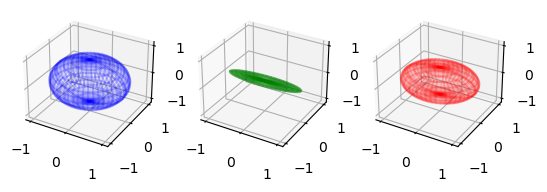

In [96]:
All_FAs = [.1,.9,.3]
All_rotations = [np.array([0,0,0]),np.array([0,0,0]),np.array([0,0,0])]
if 1 == 1:
    FA_fast, FA_med, FA_slow = All_FAs[0],All_FAs[1], All_FAs[2] # the anisotropies
    fastrot,medrot,slowrot = All_rotations[0], All_rotations[1], All_rotations[2] #the original ellipsoid rotations (in the lab frame, so not all aligned in same direction)
    
    #create the three compartment ellipsoids rotated in lab-space, and then rotate along the b-value direction
    x_fast,y_fast,z_fast,abc_fast = generate_rotated_anisotropic_ellipsoid(FA_fast,fastrot) # but then thetaxyz are same for fast, med, slow, because it's measured in the same lab-frame direction
    x_med,y_med,z_med,abc_med = generate_rotated_anisotropic_ellipsoid(FA_med,medrot)
    x_slow,y_slow,z_slow,abc_slow = generate_rotated_anisotropic_ellipsoid(FA_slow,slowrot)
    
    
    fast_compartment = [x_fast,y_fast,z_fast,abc_fast]
    med_compartment = [x_med,y_med,z_med,abc_med]
    slow_compartment = [x_slow,y_slow,z_slow,abc_slow]
    
    print('wanted: ', FA_fast, 'got: ', Calc_FA(abc_fast[0],abc_fast[1],abc_fast[2]))
    print('wanted: ', FA_med, 'got: ', Calc_FA(abc_med[0],abc_med[1],abc_med[2]))
    print('wanted: ', FA_slow, 'got: ', Calc_FA(abc_slow[0],abc_slow[1],abc_slow[2]))
    print('rotated: ', All_rotations)
    
    
    fig = pl.figure()
    ax = fig.add_subplot(131,projection='3d')
    ax.plot_wireframe(x_fast, y_fast, z_fast,  rstride=4, cstride=4, color='b', alpha=0.2)
    set_axes_equal(ax)
    ax = fig.add_subplot(132,projection='3d')
    ax.plot_wireframe(x_med, y_med, z_med,  rstride=4, cstride=4, color='g', alpha=0.2)
    set_axes_equal(ax)
    ax = fig.add_subplot(133,projection='3d')
    ax.plot_wireframe(x_slow, y_slow, z_slow,  rstride=4, cstride=4, color='r', alpha=0.2)
    set_axes_equal(ax)
    #pl.savefig('/Users/neuroimaging/Desktop/Ellipsoid_Calc_FA41.png',format='png',dpi=120)
    pl.show()
    
    
    


# Now rotate all 3 in 3 random ways


wanted:  0.12 got:  0.1290360533711043
wanted:  0.9 got:  0.9034744929309876
wanted:  0.3 got:  0.2971923244370802
rotated:  [array([2.5065375 , 2.73796232, 3.78526343]), array([0.58051032, 2.52305237, 2.01379114]), array([4.03386632, 6.17143179, 2.86500738])]


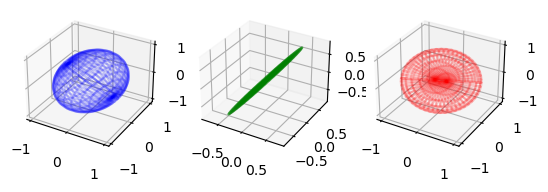

In [97]:
All_FAs = [.12,.9,.3]
fast_rot = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = 3)
med_rot = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = 3)
slow_rot = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = 3)

All_rotations = [fast_rot, med_rot, slow_rot]
if 1 == 1:
    FA_fast, FA_med, FA_slow = All_FAs[0],All_FAs[1], All_FAs[2] # the anisotropies
    fastrot,medrot,slowrot = All_rotations[0], All_rotations[1], All_rotations[2] #the original ellipsoid rotations (in the lab frame, so not all aligned in same direction)
    
    #create the three compartment ellipsoids rotated in lab-space, and then rotate along the b-value direction
    x_fast,y_fast,z_fast,abc_fast = generate_rotated_anisotropic_ellipsoid(FA_fast,fastrot) # but then thetaxyz are same for fast, med, slow, because it's measured in the same lab-frame direction
    x_med,y_med,z_med,abc_med = generate_rotated_anisotropic_ellipsoid(FA_med,medrot)
    x_slow,y_slow,z_slow,abc_slow = generate_rotated_anisotropic_ellipsoid(FA_slow,slowrot)
    
    fast_compartment = [x_fast,y_fast,z_fast,abc_fast]
    med_compartment = [x_med,y_med,z_med,abc_med]
    slow_compartment = [x_slow,y_slow,z_slow,abc_slow]
    
    print('wanted: ', FA_fast, 'got: ', Calc_FA(abc_fast[0],abc_fast[1],abc_fast[2]))
    print('wanted: ', FA_med, 'got: ', Calc_FA(abc_med[0],abc_med[1],abc_med[2]))
    print('wanted: ', FA_slow, 'got: ', Calc_FA(abc_slow[0],abc_slow[1],abc_slow[2]))
    print('rotated: ', All_rotations)
    fig = pl.figure()
    ax = fig.add_subplot(131,projection='3d')
    #ax.set_aspect('equal')
    ax.plot_wireframe(x_fast, y_fast, z_fast,  rstride=4, cstride=4, color='b', alpha=0.2)
    set_axes_equal(ax)
    ax = fig.add_subplot(132,projection='3d')
    ax.plot_wireframe(x_med, y_med, z_med,  rstride=4, cstride=4, color='g', alpha=0.2)
    set_axes_equal(ax)
    ax = fig.add_subplot(133,projection='3d')
    ax.plot_wireframe(x_slow, y_slow, z_slow,  rstride=4, cstride=4, color='r', alpha=0.2)
    set_axes_equal(ax)
    #pl.savefig('/Users/neuroimaging/Desktop/Ellipsoid_Calc_FA41.png',format='png',dpi=120)
    pl.show()

# Now measure along x, y, and z (where x, y, and z are assumed to be the orthonormal b-value directions, i.e. the lab frame). 

This is based on 'GetOrthogonalD_thetas' function

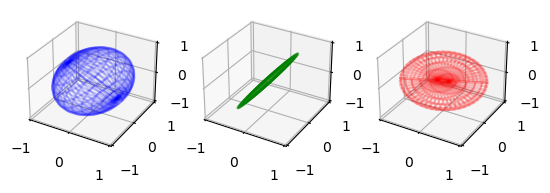

original:  [1.         0.99000702 0.79722728]
new:  0.9050735231246141 0.9705204941033474 0.8712196332651772
original:  [1.         0.06156587 0.09081425]
new:  0.07453829306475551 0.12918817436878924 0.08282666373322228
original:  [1.         0.79694198 0.481454  ]
new:  0.9485955374908764 0.5611055011812807 0.6124535773139215


In [108]:
est_FAS = [.12,.9,.3] #true fractional anisotropy, proof it is all due to FA... 
D_traces = [diff_fast,diff_med, diff_slow] #true D coefficients
assumed_rots = All_rotations
if 1 == 1:
    fast_compartment, med_compartment, slow_compartment = CreateThreeEllipsoidalCompartments(est_FAS,assumed_rots)
    
    [x_fast,y_fast,z_fast,abc_fast] = fast_compartment
    [x_med,y_med,z_med,abc_med] = med_compartment
    [x_slow,y_slow,z_slow,abc_slow] =slow_compartment
    
    
    fig = pl.figure()
    ax = fig.add_subplot(131,projection='3d')
    #ax.set_aspect('equal')
    ax.plot_wireframe(x_fast, y_fast, z_fast,  rstride=4, cstride=4, color='b', alpha=0.2)
    set_axes_equal(ax)
    ax.axes.set_xlim3d(left=-1, right=1) 
    ax.axes.set_ylim3d(bottom=-1, top=1) 
    ax.axes.set_zlim3d(bottom=-1, top=1) 
    ax = fig.add_subplot(132,projection='3d')
    ax.plot_wireframe(x_med, y_med, z_med,  rstride=4, cstride=4, color='g', alpha=0.2)
    set_axes_equal(ax)
    ax.axes.set_xlim3d(left=-1, right=1) 
    ax.axes.set_ylim3d(bottom=-1, top=1) 
    ax.axes.set_zlim3d(bottom=-1, top=1) 
    ax = fig.add_subplot(133,projection='3d')
    ax.plot_wireframe(x_slow, y_slow, z_slow,  rstride=4, cstride=4, color='r', alpha=0.2)
    set_axes_equal(ax)
    ax.axes.set_xlim3d(left=-1, right=1) 
    ax.axes.set_ylim3d(bottom=-1, top=1) 
    ax.axes.set_zlim3d(bottom=-1, top=1) 
    #pl.savefig('/Users/neuroimaging/Desktop/Ellipsoid_Calc_FA41.png',format='png',dpi=120)
    pl.show()
    
    #now measure along the given b-value direction
    x_theta_fast,y_theta_fast,z_theta_fast = find_axes(x_fast,y_fast,z_fast) #just get the length of the ellipsoid along the normal axis (i.e. 3 random orthogonal directions)
    x_theta_med,y_theta_med,z_theta_med = find_axes(x_med,y_med,z_med) #just get the length of the ellipsoid along the normal axis (i.e. 3 random orthogonal directions)
    x_theta_slow,y_theta_slow,z_theta_slow = find_axes(x_slow,y_slow,z_slow) #just get the length of the ellipsoid along the normal axis (i.e. 3 random orthogonal directions)
    
    x_thetas = [x_theta_fast, x_theta_med, x_theta_slow]
    abc_s = [fast_compartment[3],med_compartment[3],slow_compartment[3]]
    
    #compare effect of new axes post-rotation
    print('original: ',abc_fast)#, 'FA: ', Calc_FA(abc_fast[0],abc_fast[1],abc_fast[2] ))
    print('new: ', x_theta_fast,y_theta_fast,z_theta_fast)#, 'FA: ', Calc_FA(x_theta_fast, y_theta_fast, z_theta_fast))   
    
    print('original: ',abc_med)
    print('new: ', x_theta_med,y_theta_med,z_theta_med)
    
    print('original: ',abc_slow)
    print('new: ', x_theta_slow,y_theta_slow,z_theta_slow)
    
    
    # compare single direction versus averaged 3: 
    

# Now compare multiply the ellipsoids by diffusion coefficient (scale it) and get the new values along the axes

based on GetorthogonalD_thetas and Scale_Ds

In [119]:
D_traces = [diff_fast,diff_med, diff_slow] #true D coefficients
abc_s = [fast_compartment[3],med_compartment[3],slow_compartment[3]] 
if 1 == 1:
    # if single direction
    thetas = [x_theta_fast, x_theta_med, x_theta_slow] #the rotated
    D_thetas = np.zeros(len(D_traces))
    for n in range(len(D_traces)): #here n is fast, medium, or slow compartments. i.e. the 3 ellipsoids
        D_n = 3*D_traces[n]/sum(abc_s[n]) #normalize to ellipsoid (basically normalize to 1)
        D_thetas[n] = D_n*thetas[n] #multiply by diffusion strength along b-value direction 
    print(D_thetas)
    
    #if averaged
    fast_averaged = mean([x_theta_fast,y_theta_fast,z_theta_fast])
    med_averaged = mean([x_theta_med,y_theta_med,z_theta_med])
    slow_averaged = mean([x_theta_slow,y_theta_slow,z_theta_slow])
    thetas = [fast_averaged, med_averaged, slow_averaged]
    D_thetas = np.zeros(len(D_traces))
    for n in range(len(D_traces)): #here n is fast, medium, or slow compartments. i.e. the 3 ellipsoids
        D_n = 3*D_traces[n]/sum(abc_s[n]) #normalize to ellipsoid (basically normalize to 1)
        D_thetas[n] = D_n*thetas[n] #multiply by diffusion strength along b-value direction 
    print(D_thetas)
    
    #if true (if perfectly aligned along axes)
    thetas = [sum(abc_s[0])/3, sum(abc_s[1])/3, sum(abc_s[2])/3]
    D_thetas = np.zeros(len(D_traces))
    for n in range(len(D_traces)): #here n is fast, medium, or slow compartments. i.e. the 3 ellipsoids
        D_n = 3*D_traces[n]/sum(abc_s[n]) #normalize to ellipsoid (basically normalize to 1)
        D_thetas[n] = D_n*thetas[n] #multiply by diffusion strength along b-value direction 
    print(D_thetas)
    
    #expected
    print(D_traces)

[0.17534934 0.00112547 0.00187355]
[0.17738963 0.00144224 0.00139714]
[0.18   0.0058 0.0015]
[0.18, 0.0058, 0.0015]


# Debugging complete. 

Changes to note: 

1) in 'GetOrthogonalD_thetas', the rotation is removed. THis is because as the code is, the 3 compartments are generated and rotated in 3 different ways. This means that the b-values can still be read in the labview, and it does not have to be rotated again. 

2) in 'CreateThreeEllipsoidalCompartments', the fast compartment had a typo and was saving the incorrect compartment. that has been corrected. 

Now implemented in 'SimulationOfKidneySignal' notebook. 

Mira Jan 25 2024